## Setup

In [4]:
!pip install  pandas

!pip install  emoji

!pip install leia-br


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
from LeIA import SentimentIntensityAnalyzer

import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import emoji
import re

class_names = [
    "extremamente negativo",
    "negativo",
    "neutro",
    "positivo",
    "extremamente positivo",
]

# score | score_reanotado_gemini
score_column = "score"

dataset_name = "1_dataset_original_colunas_selecionadas_dados_validacao.csv"

In [37]:
df = pd.read_csv(dataset_name)

df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450 entries, 0 to 449
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  450 non-null    object
 1   score    450 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 7.2+ KB


In [38]:
# =================================
# Obter Sentimento
# =================================


def get_sentiment(rating):
    rating = int(rating)
    if rating == 1:
        return 0
    elif rating == 2:
        return 1
    elif rating == 3:
        return 2
    elif rating == 4:
        return 3
    else:
        return 4

In [39]:
# ======================
# Conversão de emojis
# ======================

# Exemplo de uso do emoji
print(
    emoji.demojize(
        "😍, 😂, 😘, 😡, ❤️, 👍, 👎, ⭐",
        language="pt",
    )
)


def converter_emojis(text):
    """
    Converte emojis em texto, garantindo que haja um espaço antes da descrição do emoji.
    """
    # Primeiro, converte o emoji para o formato :nome_do_emoji:
    text_demojized = emoji.demojize(text, language="pt")

    # A função lambda é aplicada a cada emoji encontrado pelo padrão r':([^:\s]+):'
    # m.group(1) captura apenas o nome do emoji (sem os dois pontos)
    # Em seguida, substitui '_' por ' ' e adiciona um espaço no início
    def replace_emoji(m):
        emoji_name = m.group(1)
        emoji_text = emoji_name.replace("_", " ")
        return f" {emoji_text}"

    # Usa re.sub para encontrar todos os padrões de emoji e aplicar a função de substituição
    text_final = re.sub(r":([^:\s]+):", replace_emoji, text_demojized)

    return text_final

:rosto_sorridente_com_olhos_de_coração:, :rosto_chorando_de_rir:, :rosto_mandando_um_beijo:, :rosto_furioso:, :coração_vermelho:, :polegar_para_cima:, :polegar_para_baixo:, :estrela_branca_média:


In [40]:
def remover_espacos_duplicados(text):
    return " ".join(text.split())

In [41]:
frase1 = "Eu    amo   Python!"
frase2 = "Vamos    comemorar   🎉✨"
frase3 = "Isso   está   correto✅"

frase1SemEmojis = converter_emojis(frase1)
frase2SemEmojis = converter_emojis(frase2)
print(f"Sem emojis: '{frase1SemEmojis}'")
print(f"Sem emojis: '{frase2SemEmojis}'")
frase1SemEspacosDuplicados = remover_espacos_duplicados(frase1SemEmojis)
frase2SemEspacosDuplicados = remover_espacos_duplicados(frase2SemEmojis)
print(f"Sem espaços duplicados: '{frase1SemEspacosDuplicados}'")
print(f"Sem espaços duplicados: '{frase2SemEspacosDuplicados}'")

Sem emojis: 'Eu    amo   Python!'
Sem emojis: 'Vamos    comemorar    cone de festa brilhos'
Sem espaços duplicados: 'Eu amo Python!'
Sem espaços duplicados: 'Vamos comemorar cone de festa brilhos'


In [42]:
def marcar_incoerentes_leia(df: pd.DataFrame) -> pd.DataFrame:
    """Verifica discrepâncias usando a biblioteca Leia
    Leia atribui uma pontuação de sentimento para cada comentário com base em seu conteúdo.
    A saída da análise é um objeto com os seguintes campos:
        - pos:
        - neu:
        - neg:
        - compound:


    O valor da compound pode ser utilizado para descrever o sentimento predominante no texto, por meio dos limites de valores:
        - Sentimento extremamente positivo: (>= 0.5) compound >= 0.5
        - Sentimento positivo: [0.05  até  0.5) compound >= 0.05
        - Sentimento neutro: (-0.05  até   0.05) compound > -0.05 and compound < 0.05
        - Sentimento negativo: (-0.5  até  -0.05] compound > -0.5
        - Sentimento extremamente negativo: (<= -0.5) compound <= -0.5

    Alternativa mais simples (usada em exemplos oficiais do VADER e LeiA):
        - Sentimento positivo : compound >= 0.05
        - Sentimento neutro : ( compound > -0.05) e ( compound < 0.05)
        - Sentimento negativo : compound <= -0.05

    Para verificar a discrepância, os Artigos utilizam:
        - Tendenciosa: score > 3 e compound < -0,5 - Esse foi utilizado no artigo que utiliza o VADER - Sadiq et al. (2021)
        - Tendenciosa: score > 3 e polaridade < 0,5 - Esse foi utilizado no artigo que utiliza o TextBlob - Aljrees et al. (2024).

    """

    df["leia_score"] = df["content"].apply(
        lambda text: SentimentIntensityAnalyzer().polarity_scores(str(text))["compound"]
    )

    df["leia_incoerente"] = df.apply(
        # Opção 1: Limites:
        # Extremamente positivo: (>= 0.5)
        # Positivo: [0.05  até  0.5)
        # Neutro: (-0.05  até   0.05)
        # Negativo: (-0.5  até  -0.05]
        # Extremamente negativo: (<= -0.5)
        # lambda row: (
        #     (row[score_column] < 3 and row["leia_score"] >= 0.05)
        #     or (row[score_column] > 3 and row["leia_score"] <= -0.05)
        # ),
        # Opção 2:
        # Limites de sentimento utilizados nos Artigos
        lambda row: (
            (row[score_column] < 3 and row["leia_score"] >= 0.5)
            or (row[score_column] > 3 and row["leia_score"] <= -0.5)
        ),
        axis=1,
    )

    return df

In [43]:
def remover_incoerentes_leia(df: pd.DataFrame) -> pd.DataFrame:
    df = df[~df["leia_incoerente"]]
    df = df.reset_index(drop=True)
    return df

In [44]:
def limpeza_texto(text):
    text = converter_emojis(text)
    text = remover_espacos_duplicados(text)
    # text = converter_para_minusculas(text)
    return text

In [45]:
marcar_incoerentes_leia(df)

df["leia_incoerente"].value_counts()

leia_incoerente
False    378
True      72
Name: count, dtype: int64

In [46]:
df = remover_incoerentes_leia(df)

In [47]:
df["content"] = df["content"].apply(limpeza_texto)

# Obter sentimento
df["sentiment"] = df[score_column].apply(get_sentiment)

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378 entries, 0 to 377
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   content          378 non-null    object 
 1   score            378 non-null    int64  
 2   leia_score       378 non-null    float64
 3   leia_incoerente  378 non-null    bool   
 4   sentiment        378 non-null    int64  
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 12.3+ KB


In [49]:
df.head()

,content,score,leia_score,leia_incoerente,sentiment
0,"tive medo de comprar, mais quando comprei pela...",5,0.9552,False,4
1,"Nunca tive problemas com Shein, meu único prob...",1,-0.7964,False,0
2,"gosto das roupas, as vezes fotos mais intensas...",3,0.0258,False,2
3,"O aplicativo, a experiência de compra e o aten...",4,-0.3919,False,3
4,o aplicativo é muito bom só deixa a desejar no...,3,0.7650,False,2


C:\Users\lucas\AppData\Local\Temp\ipykernel_18572\385892566.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=sentiment_counts.values, palette="viridis")


Text(0, 0.5, 'Número de Avaliações')

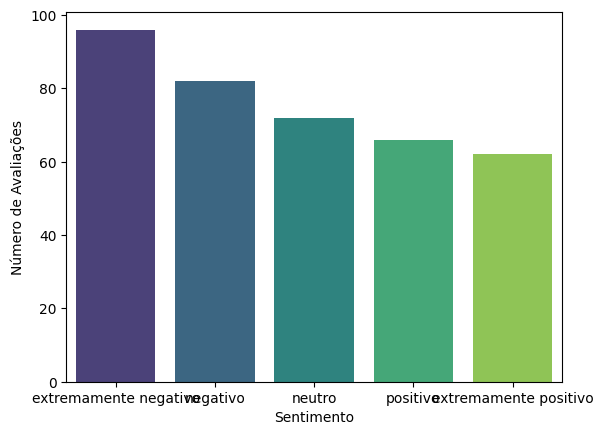

In [50]:
# Contar as avaliações por score
sentiment_counts = df.sentiment.value_counts()

# Plotar as contagens por sentimento
sns.barplot(x=class_names, y=sentiment_counts.values, palette="viridis")

plt.xlabel("Sentimento")
plt.ylabel("Número de Avaliações")

In [51]:
base_name = os.path.splitext(dataset_name)[0]

df.to_csv(
    f"{base_name}_limpeza_demojize_leia.csv", index=False, header=True, encoding="utf-8"
)